In [3]:
import pickle
import numpy as np
import lightgbm as lgb

In [4]:
distance_func = lambda d: d

In [21]:
def get_data(path: str):
    with open(path, "rb") as f:
        json_data = pickle.load(f)
        
    X = []
    y = []

    for k, v in json_data.items():
#         print(k)
        node_num, minterm_num = k
        for d_tuple, size in v.items():
            distance = sum(map(distance_func, d_tuple))
            if [node_num, minterm_num, distance] in X:
                index = X.index([node_num, minterm_num, distance])
                y[index] += size
            else:
                X.append([node_num, minterm_num, distance])
                y.append([np.mean(size)])
    
    y = list(map(lambda l: np.mean(l), y))

    X = np.array(X)
    y = np.array(y)
    
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    return data
        

In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = get_data("distance_size_full.pkl")

cols = ["node_num", "minterm_num", "distance", "size"]

data = pd.DataFrame(data, columns=cols)
data["distance"] = data['distance'] / data['minterm_num']

data_train, data_test = train_test_split(data, test_size=0.2, random_state=23)


In [29]:
from sklearn.metrics import make_scorer

def relative_error(y_true, y_pred):
    return sum(np.abs(y_true - y_pred) / y_true)

my_scorer = make_scorer(relative_error, greater_is_better=False)



In [33]:
from hypergbm import make_experiment

# experiment = make_experiment(data_train, target="size", max_trials=300, cv=True, num_folds=5)
experiment = make_experiment(data_train, target="size", max_trials=100, early_stopping_rounds=20, num_folds=4)
estimator = experiment.run()
print(estimator)

ExperimentProcessWidget(initData='{"task": "regression", "datasets": [{"kind": "Train", "task": "regression", …

Pipeline(steps=[('data_clean',
                 DataCleanStep(cv=True,
                               data_cleaner_args={'correct_object_dtype': True,
                                                  'drop_columns': None,
                                                  'drop_constant_columns': True,
                                                  'drop_duplicated_columns': False,
                                                  'drop_idness_columns': True,
                                                  'drop_label_nan_rows': True,
                                                  'int_convert_to': 'float',
                                                  'nan_chars': None,
                                                  'reduce_mem_usage': False,
                                                  'reserve_columns': None},
                               name='data_clean')),
                ('est...
                 GreedyEnsemble(weight=[0.45, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0

In [7]:
# def read_pickle(pickle_path: str):
#     with open(pickle_path, "rb") as f:
#         data = pickle.load(f)

#     return data

# estimator = read_pickle("re_d_model.pkl")

In [34]:
y_test = data_test['size'].to_numpy()
error = (np.abs(estimator.predict(data_test) - y_test)) / y_test
print(np.mean(error))
print(np.std(error))
print(np.max(error))
print(np.min(error))

0.04233919720942963
0.05728536212670419
0.6505282848600357
0.00012537974791780384


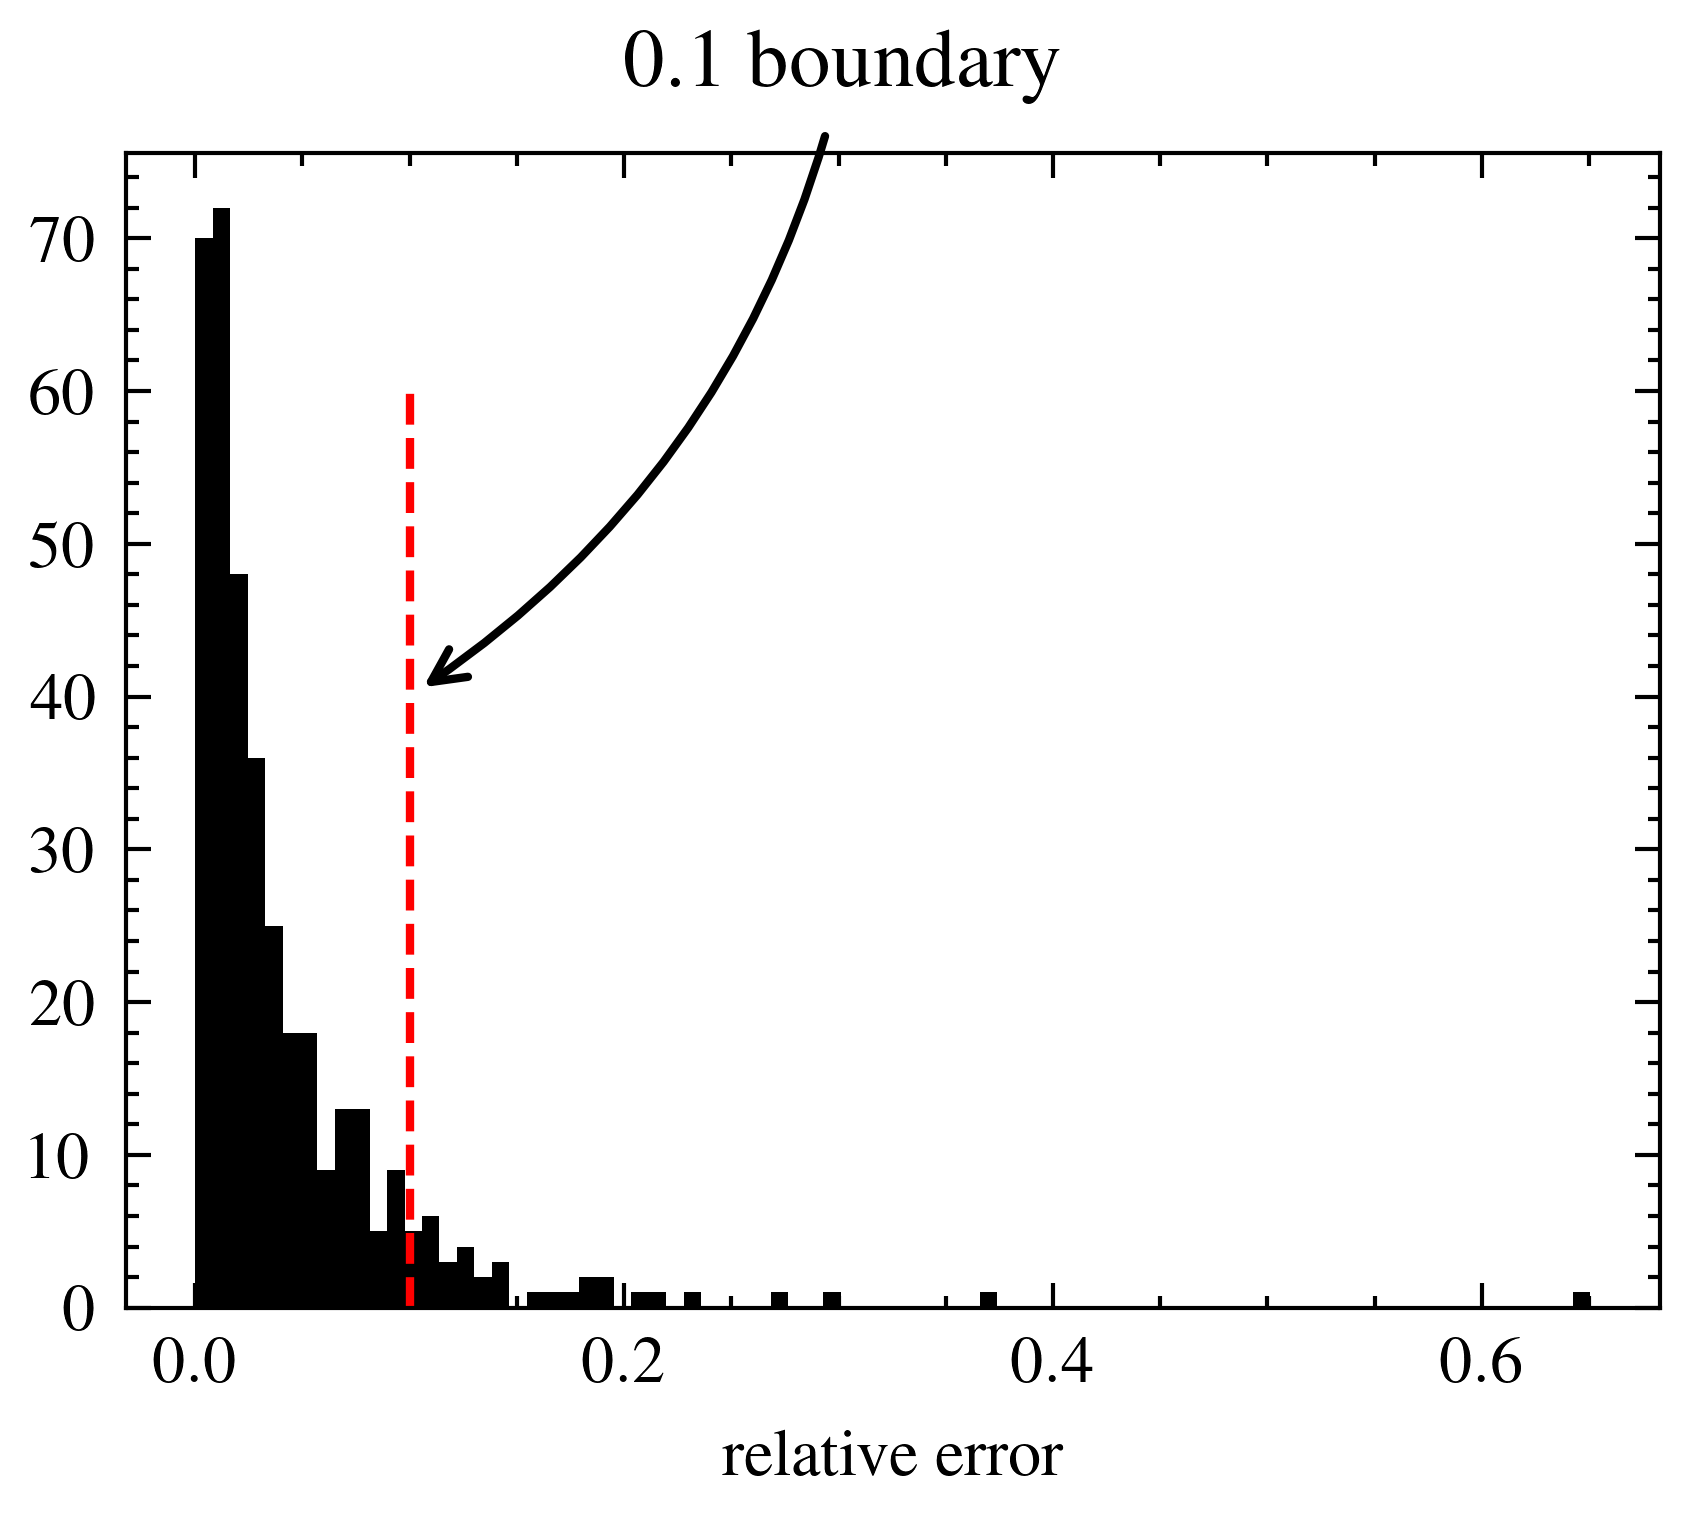

In [35]:
import matplotlib.pyplot as plt
import scienceplots

# plt.style.use("seaborn")
plt.style.use(["science", "ieee"])

fig, ax = plt.subplots()
ax.hist(error, bins=80)
ax.set_xlabel("relative error")
# ax.text(0.7, 40, "The outlier with high relative error \n but small absolute error.")
ax.annotate(
    "The outlier \n with high relative error \n but small absolute error.",
    # fontsize=10,
    xy=(0.985, 2),
    xytext=(0.5, 40),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"),
)

zeroone = [0.1, 0.1]
y_range = [0, 60]
plt.plot(zeroone, y_range, "r--")
ax.annotate(
    "0.1 boundary",
    fontsize=10,
    xy=(0.1, 40),
    xytext=(0.2, 80),
    arrowprops=dict(arrowstyle="->", fc="red", connectionstyle="arc3,rad=-0.2")
)

# ax.set_xscale("log")
# ax.set_ylabel("n")
fig.show()
fig.savefig("relative_error.pdf")


In [36]:
import pickle
with open('rd_model.pkl','wb') as f:
  pickle.dump(estimator, f)

In [42]:
def read_pickle(pickle_path: str):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    return data

estimator = read_pickle("rd_model.pkl")

In [43]:
data_test

,node_num,minterm_num,distance,size
18,4.0,2.0,4.000000,7.615385
1439,12.0,30.0,2.466667,160.000000
46,4.0,8.0,1.000000,7.120968
363,7.0,10.0,1.900000,34.761905
919,9.0,50.0,1.540000,156.875000
...,...,...,...,...
813,9.0,12.0,2.666667,61.600000
695,9.0,4.0,4.000000,25.780000
1729,15.0,20.0,4.100000,161.750000
1387,12.0,15.0,2.733333,93.900000


In [46]:
cols = ["node_num", "minterm_num", "distance"]

data = pd.DataFrame(
            [[12, 30, 2.46]],
            columns=cols,
        )
estimator.predict(data)

array([159.02745285])